In [9]:
# -*- coding: utf-8 -*-
# cybos related
import sys
import os
proj_dir = "C:\\Users\\sh\\Documents\\devbox\\github\\auto_invest"
sys.path.append(proj_dir)
from src.utils.database import dbMeta

# math
import numpy as np
import pandas as pd
from datetime import date, datetime, timedelta

# visualization with Korean
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
font_loc = os.path.join(proj_dir, "asset\\human_myeongjo.ttf")
font_name = fm.FontProperties(fname=font_loc).get_name()
font = {
    'family': font_name,
    'weight': 'bold',
}
mpl.rc('font', **font)
mpl.rc('text', color='white')
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

In [76]:
item_cd_kakao = 'A035720'
item_cd_amore_g = 'A002790'
sql = """
SELECT 
    *
FROM market_eye_today
WHERE `종목코드` = '{item_cd}'
;
""".format(item_cd=item_cd_kakao)
engine = dbMeta.get_mysql_engine()
snapshot = pd.read_sql(sql, engine)
snapshot.describe()

C:\Users\sh\Anaconda3\lib\site-packages\pymysql\cursors.py:166: Warning: (1366, "Incorrect string value: '\\xB4\\xEB\\xC7\\xD1\\xB9\\xCE...' for column 'VARIABLE_VALUE' at row 480")
  result = self._query(query)


,SEQ,대비부호,전일대비,현재가,시가,고가,저가,매도호가,매수호가,거래량,...,ELW_델타,ELW_발행수량,ELW_베가,ELW_세타,ELW_손익분기율,ELW_역사적변동성,ELW_자본지지점,ELW_패리티,ELW_프리미엄,ELW_베리어
count,103.000000,103.000000,103.000000,103.000000,103.0,103.000000,103.000000,103.000000,103.000000,103.000000,...,1.030000e+02,103.0,103.0,103.0,103.0,103.0,103.0,103.0,103.0,103.0
mean,25047.737864,50.495146,1155.339806,109655.339806,110000.0,111485.436893,109072.815534,109820.388350,109320.388350,255172.990291,...,-1.784152e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,14364.665788,1.092522,902.146477,902.146477,0.0,147.799392,725.609166,862.777006,862.777006,89753.333260,...,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,637.000000,50.000000,-1000.000000,107500.000000,110000.0,110000.000000,107500.000000,108000.000000,107500.000000,24105.000000,...,-1.784152e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,12786.500000,50.000000,1000.000000,109500.000000,110000.0,111500.000000,108500.000000,109500.000000,109000.000000,195081.500000,...,-1.784152e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,25087.000000,50.000000,1500.000000,110000.000000,110000.0,111500.000000,109500.000000,110000.000000,109500.000000,240130.000000,...,-1.784152e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,36990.500000,50.000000,1500.000000,110000.000000,110000.0,111500.000000,109500.000000,110500.000000,110000.000000,344082.000000,...,-1.784152e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,50076.000000,53.000000,2500.000000,111000.000000,110000.0,111500.000000,109500.000000,111500.000000,111000.000000,425326.000000,...,-1.784152e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [77]:
def get_time_derivative(df, time_col, deriv_col, index_is_time=False):
    if index_is_time:
        df['dt'] = pd.Series(df.index.tolist(), index=df.index).diff().apply(lambda x: x.total_seconds())
    else:    
        df['dt'] = df[time_col].apply(lambda x: x.timestamp()).diff()
    df['col_dt'] = df[deriv_col].diff()
    c_name = 'deriv_%s' % deriv_col
    df[c_name] = df['col_dt'] / df['dt']
    df.drop(['dt', 'col_dt'], inplace=True, errors='ignore')
    df = df.fillna(0)
    return (df, c_name)

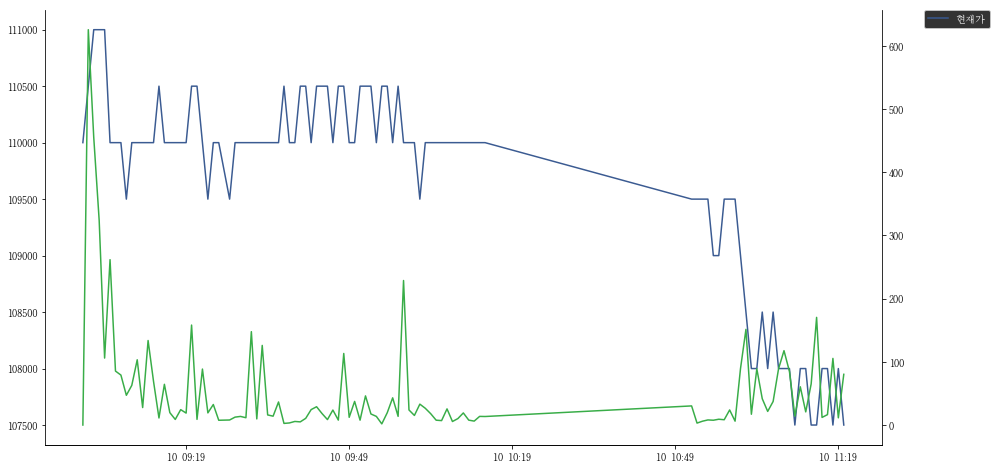

In [78]:
plotter = snapshot
plotter = plotter.set_index('time')
plotter.head(10)
target = '현재가'
fig, ax = plt.subplots(figsize=(15, 8))
title = r"%s over time" % target

"""     PLOT LINES      """
ax.plot(plotter[target], sns.xkcd_rgb["denim blue"], label=target)

"""     GET TWIN AXES    """
ax2 = ax.twinx()
plotter, deriv_col = get_time_derivative(plotter, 'time', '거래량', index_is_time=True)
ax2.plot(plotter[deriv_col], sns.xkcd_rgb["medium green"], label='volume')

"""   ADD LEGEND   """
legend = ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
legend.get_frame().set_facecolor('#000000')
sns.despine(ax=ax, right=True, left=False)
sns.despine(ax=ax2, right=False, left=True)

In [79]:
plt.close()

In [80]:
plotter.head(10)

,SEQ,종목코드,대비부호,전일대비,현재가,시가,고가,저가,매도호가,매수호가,...,ELW_역사적변동성,ELW_자본지지점,ELW_패리티,ELW_프리미엄,ELW_베리어,QUERY_DT,LOAD_DT,dt,col_dt,deriv_거래량
time,,,,,,,,,,,,,,,,,,,,,
2017-08-10 09:00:00,637,A035720,50,1500,110000,110000,110000,109500,110000,109500,...,0,0,0,0,0,0,2017-08-10 09:00:12,0.0,0.0,0.000000
2017-08-10 09:01:00,1285,A035720,50,2000,110500,110000,111500,109500,111000,110500,...,0,0,0,0,0,0,2017-08-10 09:01:06,60.0,37522.0,625.366667
2017-08-10 09:02:00,1728,A035720,50,2500,111000,110000,111500,109500,111000,110500,...,0,0,0,0,0,0,2017-08-10 09:02:06,60.0,27310.0,455.166667
2017-08-10 09:03:00,2192,A035720,50,2500,111000,110000,111500,109500,111500,111000,...,0,0,0,0,0,0,2017-08-10 09:03:06,60.0,19422.0,323.700000
2017-08-10 09:04:00,2599,A035720,50,2500,111000,110000,111500,109500,111000,110500,...,0,0,0,0,0,0,2017-08-10 09:04:05,60.0,6355.0,105.916667
2017-08-10 09:05:00,3031,A035720,50,1500,110000,110000,111500,109500,110500,110000,...,0,0,0,0,0,0,2017-08-10 09:05:06,60.0,15695.0,261.583333
2017-08-10 09:06:00,3481,A035720,50,1500,110000,110000,111500,109500,110500,110000,...,0,0,0,0,0,0,2017-08-10 09:06:06,60.0,5121.0,85.350000
2017-08-10 09:07:00,3933,A035720,50,1500,110000,110000,111500,109500,110000,109500,...,0,0,0,0,0,0,2017-08-10 09:07:05,60.0,4741.0,79.016667
2017-08-10 09:08:00,4415,A035720,50,1000,109500,110000,111500,109500,110000,109500,...,0,0,0,0,0,0,2017-08-10 09:08:06,60.0,2824.0,47.066667


In [81]:
"""
GET FIVE MINUTES DATA
CALCULATE VOLUME CHANGE IN PERCENTAGE AND THE PRICE FALL
GET THE STOCKCODES WHOSE CHANGE IN VOLUME WAS 10% OF THE ENTIRE DAY'S, AND THE PRICE FELL 
"""

"\nGET FIVE MINUTES DATA\nCALCULATE VOLUME CHANGE IN PERCENTAGE AND THE PRICE FALL\nGET THE STOCKCODES WHOSE CHANGE IN VOLUME WAS 10% OF THE ENTIRE DAY'S, AND THE PRICE FELL \n"

In [82]:
five_min_ago = datetime.now() - timedelta(minutes=5)
five_min_ago = five_min_ago.replace(second=0, microsecond=0).strftime('%Y-%m-%d %H:%M:%S')
item_cd_kakao = 'A035720'
item_cd_amore_g = 'A002790'
sql = """
SELECT 
    `종목코드`
    , `종목명`
    , `거래량`
    , `현재가`
    , `time`
FROM market_eye_today
WHERE `time` >= '{time}'
GROUP BY 1, 2, 3, 4, 5 
;
""".format(time=five_min_ago)
engine = dbMeta.get_mysql_engine()
snapshot = pd.read_sql(sql, engine)
print(snapshot.describe())


SELECT 
    `종목코드`
    , `종목명`
    , `거래량`
    , `현재가`
    , `time`
FROM market_eye_today
WHERE `time` >= '2017-08-10 11:17:00'
GROUP BY 1, 2, 3, 4, 5 
;



C:\Users\sh\Anaconda3\lib\site-packages\pymysql\cursors.py:166: Warning: (1366, "Incorrect string value: '\\xB4\\xEB\\xC7\\xD1\\xB9\\xCE...' for column 'VARIABLE_VALUE' at row 480")
  result = self._query(query)


                거래량           현재가
count  2.801000e+03  2.801000e+03
mean   2.129528e+05  6.579033e+04
std    6.180574e+05  1.771213e+05
min    1.000000e+00  2.550000e+02
25%    1.272400e+04  5.930000e+03
50%    4.023700e+04  1.745000e+04
75%    1.328960e+05  5.850000e+04
max    6.850422e+06  2.303000e+06


In [86]:
snapshot['종목코드'].unique().tolist()

['A000020',
 'A000030',
 'A000040',
 'A000050',
 'A000060',
 'A000070',
 'A000075',
 'A000080',
 'A000087',
 'A000100',
 'A000120',
 'A000140',
 'A000145',
 'A000150',
 'A000180',
 'A000210',
 'A000215',
 'A000220',
 'A000225',
 'A000227',
 'A000230',
 'A000240',
 'A000270',
 'A000300',
 'A000320',
 'A000325',
 'A000370',
 'A000390',
 'A000400',
 'A000430',
 'A000480',
 'A000490',
 'A000540',
 'A000545',
 'A000547',
 'A000590',
 'A000640',
 'A000650',
 'A000660',
 'A000670',
 'A000720',
 'A000725',
 'A000760',
 'A000810',
 'A000815',
 'A000850',
 'A000860',
 'A000880',
 'A000885',
 'A00088K',
 'A000890',
 'A000910',
 'A000950',
 'A000970',
 'A000990',
 'A000995',
 'A001020',
 'A001040',
 'A001045',
 'A001060',
 'A001080',
 'A001120',
 'A001130',
 'A001200',
 'A001210',
 'A001230',
 'A001250',
 'A001260',
 'A001270',
 'A001275',
 'A001290',
 'A001340',
 'A001360',
 'A001380',
 'A001390',
 'A001420',
 'A001430',
 'A001440',
 'A001450',
 'A001470',
 'A001500',
 'A001510',
 'A001515',
 'A0

In [89]:
snapshot[snapshot['종목코드'] == 'A000150']['종목명'].unique().tolist()[0]

'두산'